<h2>Import Modules</h2>

In [4]:
from CAM.datareader import StanfordGenerator
from CAM.datareader import Datawriter
from CAM.datareader import Datareader
from CAM.blocks import CAMConv
from CAM.blocks import AddCAMCoords
from CAM.dataaugmentation import *
from CAM.losses import *
import glob
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import aggdraw
import math
import pprint as pp

<h2>Some Settings</h2>

In [5]:
scale = 3
video_frame_w, video_frame_h = 3840//scale, 2160//scale

<h2>Create Tensor Records</h2>
<p>We create a toy example in which for every area we sample randombly one only example.
<br>
    Remember to modify the following variables with the desired values, keeping in mind their use:
    <ul>
      <li><strong>stanfor_dataset:</strong> Path to the 2D-3D Semantics Dataset from Stanford Uni.</li>
      <li><strong>tfrecords_dir:</strong> Temporal Directory where the created tfrecords will be saved.</li>
      <li><strong>seed:</strong> Random Seed For the Generator, the images sapled will depend on it.</li>
      <li><strong>num_areas:</strong> From 1 to 6. Number of areas used in the demo</li>
</ul>
By default we set the parameters to create one tfrecord for each area with one single image in original resolution.
</p>

In [6]:
stanford_dataset = './demo/data_augmentation/dataset_toy_example/'
tfrecords_dir = './demo/data_augmentation/tfrecords_toyexample/'
seed = 2300
max_examples = 0 # KEEP to 0 to add just one example. # Make sure there is at least this number of images
num_areas = 6
areas_dirs = [sorted(glob.glob(os.path.join(stanford_dataset,'area_'+str(ar+1)+'*/data'))) for ar in range(num_areas)]
subarea_char = [[''],['a','b']]
tfrecords_fn = [[os.path.join(tfrecords_dir,'area{}{}.tfrecord'.format(ar+1,subarea_char[len(areas_dirs[ar])-1][sb])) 
                 for sb in range(len(areas_dirs[ar]))]for ar in range(len(areas_dirs))]
# 1) Create all the TFRECORDS
gen = None
for area_dirs,area_tffiles in zip(areas_dirs,tfrecords_fn):
     for _area_dir,_area_tffile in zip(area_dirs,area_tffiles):
            gen = StanfordGenerator(_area_dir,seed=seed,size=(1080//scale,1080//scale))
            dwriter = Datawriter(_area_tffile,
                        gen,max_examples,gen.format_entry(),debug=False)
            dwriter.write()
        

<h2>Define Datareader with Data Augmentation Operations</h2>
<p>We define the Data Augmentation Parameters and Operations. This operations run online during training.
<br>
    Remember to modify the following variables with the desired values, keeping in mind their use:
    <ul>
      <li><strong>target_(w/h):</strong> Final Sensor Size after Data Augmentation.</li>
      <li><strong>pp_max_shift:</strong> Maximum principal point shifting in original resolution.</li>
</ul>
Note that this parameters like target_h/w or pp_max_shift can be modified later as parameters of the function. The rest are just set to default values. We encorage you to play with them.
<br>
The list of operations that are perform whith the data are:
<ul>
      <li><strong>Normalization</strong> Normalization operation of the tensors. These are specified in the key_norms dictionary. (Read comments in the code)</li>
      <li><strong>SaveOriginalSetup</strong> Save the original images and intrinsics (Useful for debugging and this demo).</li>
      <li><strong>RGBAugment</strong> RGB Data Augmentation.</li>
      <li><strong>FocalDataAugmentation</strong> Focal Length data augmentation. Parameters for this operation are the targets w and h, the maximum principal point shifting (pp_max_shift), horizontal mirroring (hmirror)... (Check python code for more details)</li>
</ul>
</p>
<h2>Define CAM-Convs Channels to be added</h2>
<p>
    The function <strong>add_camconvs_channels</strong> concatenates the Centered Coordinates and the Field of View maps to the image. Parameters can be modified but it could change the results of the Demo. 
</p>

In [7]:
"""
Return and iterator with that will return data samples after data augmentation.
"""
def get_datareader(list_of_files,target_w = 320//scale, target_h=480//scale,pp_max_shift=500//scale):
    kargs={
        'key_norms':{'image':[('set_shape','w','h',3)], # Set shape to the tensor with key 'image' to the values contained in keys 'w' and 'h' if they are integer. Print WARNING otherwise.
                    'normal':[('set_shape','w','h',3), # Same than previous 'set_shape' operations
                             ('set_nan',(128./255.,128./255.,128./255.)), # Values in tensor 'normal' are set to NaN if they have the value in the first parameter
                             ('cast',tf.float32), # Cast to float32
                             ('range',0.,1.,-1,1), # Normalize from 0-1 to -1,1
                             ('custom',lambda x:x)], # Custom Normalization (Does nothing, it's an example)
                    'depth':[('set_shape','w','h',1),
                             ('cast',tf.float32),
                             ('custom',lambda x:x)],
                    'intrinsics':[('custom',lambda x: tf.expand_dims(x,0) if x.shape == (4) else x)]
                        }, # Parameters for Normalization
        'target_w':target_w,
        'target_h':target_h,
        'pp_max_shift':pp_max_shift,
        'hmirror':True, # Horizontal mirror with probability of 0.5
        'debug':True, # Returns extra tensors, NOTE!!: True for tutorial
        'normal_keys':['normal'] # List of tensors that contains surface normals. 
    }
    ep = lambda x: stack_CAMDAUG(x,[Normalization,SaveOriginalSetup,
                                    RGBAugment,FocalDataAugmentation,
                                    PrepareGt],**kargs)
    parser = lambda x: gen.get_parser()(x,gen.format_entry(),extra_parse=ep)
    datareader = Datareader(list_of_files,parser = parser,buffer_size = 100 ,debug = False,shuffle=True)
    it = datareader()
    
    return it
def add_camconvs_channels(it,coord_maps=False,
               centered_coord = True,
               scale_centered_coord = 320//scale,
               norm_coord_maps = True,
               with_r = False,
               bord_dist = False,
               fov_maps = True,
               data_format='channels_last'):
    # ADD To CURRENT IMAGE
    image = it['image']
    _, h, w, _ = image.shape.as_list()
    fx,fy,cx,cy = tf.split(it['intrinsics'][:,0,:],num_or_size_splits=4,axis=-1)
    add_cam_coords = AddCAMCoords(coord_maps,centered_coord,norm_coord_maps,with_r,bord_dist,scale_centered_coord,fov_maps,data_format=data_format)
    it.update({'camconvs':add_cam_coords(it['image'],h=h,w=w,cx=cx,cy=cy,fx=fx,fy=fy)})
    # ADD ORIGINAL Images (Pre Data Augmentation)
    image = it['original']['image']
    h, w, = 1080//scale,1080//scale
    fx,fy,cx,cy = tf.split(it['original']['intrinsics'][:,0,:],num_or_size_splits=4,axis=-1)
    add_cam_coords = AddCAMCoords(coord_maps,centered_coord,norm_coord_maps,with_r,bord_dist,scale_centered_coord,fov_maps,data_format=data_format)
    it.update({'ori_camconvs':add_cam_coords(it['original']['image'],h=h,w=w,cx=cx,cy=cy,fx=fx,fy=fy)})
    return it

 
<h2>Visualization Functions and Parameters</h2>
<p>
This funtions are thought to create images with examples of different Camera Data Augmentation operations performed by our module.
</p>

 <table width="auto">
<tr>
                <td><img src="./demo/images/demo2.gif" width="75%"></td>
    </tr>
</table>


 <table width="auto">
    <tr>
                <td><img src="demo/images/image2_000001.png" alt="Not Found"></td>
                <td><img src="demo/images/image2_000003.png" alt="Not Found"></td>
                <td><img src="demo/images/image2_000005.png" alt="Not Found"></td>
                <td><img src="demo/images/image2_000007.png" alt="Not Found"></td>
    </tr>
    <tr>
                <td><img src="demo/images/image_000001.png" alt="Not Found"></td>
                <td><img src="demo/images/image_000002.png" alt="Not Found"></td>
                <td><img src="demo/images/image_000003.png" alt="Not Found"></td>
                <td><img src="demo/images/image_000004.png" alt="Not Found"></td>
    </tr>
</table>
<p>
    The operations for data augmentation are the following: 
    <ol>
        <li> Principal point shifting <strong style="color: red;"> (Red Crop)</strong></li> 
        <li> Focal Length Data Augmentation and Sensor size <strong style="color: green;">(Green Crop + Resizing)</strong> </li> 
    </ol>
    Note they are applied to the images and the camera intrinsics.
</p>


In [8]:

margin = 80//scale
pen_pp_width=10/scale
pp_r = 40/scale
pp_color = 'white'
pp_frame = 'red'
fl_frame = 'green'
output = None
def toRGBA(RGBint):
    RGBint = int(RGBint)
    Alpha = RGBint & 255
    Blue =  (RGBint >> 8) & 255
    Green = (RGBint >> 16) & 255
    Red =   (RGBint >> 24) & 255
    return [Red/255,Green/255,Blue/255,Alpha/255]
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
l=[0x24ff00ff,0x6dff00ff,0xb6ff00ff,0xf5f509ff,0xffb648ff,0xff6d91ff,0xff24daff]
l2=[0x24ff00ff,0xf5f509ff,0xff24daff]
pos = [0,0.5,1]
cmlist = [toRGBA(v) for v in l]
fvmap=make_cmap(cmlist)
#fvmap = LinearSegmentedColormap.from_list('fv',cmlist)
#fvmap = LinearSegmentedColormap.from_list('fv',cmlist2)
ccmap = cm.bwr
gross=100//scale
font_size1 = int(round(70/scale))
font_size2 = int(font_size1*1.3)
font_math = ImageFont.truetype("demo/open-sans/OpenSans-LightItalic.ttf", font_size1)
font_title = ImageFont.truetype("demo/open-sans/OpenSans-Bold.ttf", font_size2)
font_legend = ImageFont.truetype("demo/open-sans/OpenSans-Regular.ttf", font_size1)
font_matrix = ImageFont.truetype("demo/times_it.ttf", font_size1)

def paint_map(themap,vertical=True,gross=None,colmap=cm.plasma,mmin=None, mmax=None,invert=False):
    if mmin is None or mmax is None:
        mmin,mmax = np.nanmin(themap),np.nanmax(themap)
    
    norm = (themap-mmin)/(mmax-mmin)
    if gross is not None:
        if vertical:
            norm=norm[:,:gross,...]
#             print(themap[:,:1,...])
        else:
            norm=norm[:gross,...]
#             print(themap[:1,...])
    if invert:
        norm = -norm+1.0
    return Image.fromarray(np.uint8(colmap(norm)*255.),'RGBA'),mmin,mmax
def get_frame(sess,it,last_frame = None,area_n = 1, frame_n=1,percent = 0,output=None,last_x=None):
   
    frame = Image.new('RGB', (video_frame_w,video_frame_h))
    if last_frame is not None: 
        frame.paste(last_frame,(0,0))

    if output is None:
        output = sess.run(it)
    
    
    # 1. DRAW ORIGINAL RGB IMAGE
    original_image =  Image.fromarray(np.uint8(output['original']['image'][0,...]*255.),'RGB')
    original_w, original_h = original_image.size
    original_x,original_y = margin,video_frame_h-original_h-margin-2*gross
    frame.paste(original_image,(original_x,original_y))
    
    # 2. DRAW ORIGINAL DEPTH IMAGE
    original_depth_array = output['original']['depth'][0,...,0]
    original_depth_array_min,original_depth_array_max = np.nanmin(original_depth_array),np.nanmax(original_depth_array)
    norm_original_depth_array = (original_depth_array-original_depth_array_min)/(original_depth_array_max-original_depth_array_min)
    original_depth =Image.fromarray(np.uint8(cm.plasma(norm_original_depth_array)*255.),'RGBA')
    original_depth_x,original_depth_y = margin+original_w+gross//5,video_frame_h-original_h-margin-2*gross
    frame.paste(original_depth,(original_depth_x,original_depth_y))
    
    
    
    #Original Images
    draw = ImageDraw.Draw(frame)
    def draw_text(text,font,x,y,color=(255,255,255),center = True):
        w,h = draw.textsize(text,font=font)
        xx = (2*x-w)/2 if center else x
        yy = y-font.size
        draw.text((xx, yy),text,color,font=font)
        return w
        
    query_text = "Original Images {}x{}".format(original_w,original_h)
    draw_text(query_text,font_title,original_x+original_w+gross//5//2,original_y-gross//2-font_size2)

    query_text = "RGB"
    draw_text(query_text,font_legend,original_x+original_w//2,original_y-gross//2)
    query_text = "Depth"
    draw_text(query_text,font_legend,original_x+original_w+gross//5+original_w//2,original_y-gross//2)
    
    
    query_text = "Centered Coords -- cc x-axis "
    draw_text(query_text,font_math,original_x+original_w//2,original_y+original_h+gross+gross//1.2)
    query_text = "Field of View -- fov x-axis"
    draw_text(query_text,font_math,original_x+original_w+gross//5+original_w//2,original_y+original_h+gross+gross//1.2)
    
    
    # 3. DRAW ORIGINAL PRINCIPAL POINT
    d = aggdraw.Draw(frame)
    original_intrinsics = output['original']['intrinsics'][0,...]
    ppx,ppy = original_intrinsics[0,2] , original_intrinsics[0,3]
    pen = aggdraw.Pen(pp_color, pen_pp_width)
    # 3.1. DRAW ORIGINAL RGB PRINCIPAL POINT
    d.line((original_x+ppx, original_y+(ppy-pp_r),
            original_x+ppx, original_y+ppy+pp_r),pen)
    d.line((original_x+ppx-pp_r, original_y+ppy,
            original_x+ppx+pp_r, original_y+ppy),pen)
    # 3.2. DRAW ORIGINAL DEPTH PRINCIPAL POINT
    d.line((original_depth_x+ppx, original_depth_y+(ppy-pp_r),
            original_depth_x+ppx, original_depth_y+ppy+pp_r),pen)
    d.line((original_depth_x+ppx-pp_r, original_depth_y+ppy,
            original_depth_x+ppx+pp_r, original_depth_y+ppy),pen)

    d.flush()

    # 4. DRAW PRINCIPAL POINT SHIFT CROP
    pp_crop = output['r_values_principalpoint']
#     pp.pprint(pp_crop)
    bv_shift = pp_crop['bv_shift']
    tv_shift = pp_crop['tv_shift']
    lh_shift = pp_crop['lh_shift']
    rh_shift = pp_crop['rh_shift']
    pen = aggdraw.Pen(pp_frame, pen_pp_width)
    # 4.1. DRAW RGB PRINCIPAL POINT SHIFT CROP
    d.rectangle((original_x+lh_shift, original_y+tv_shift,
            original_x+original_w-rh_shift, original_y+original_h-bv_shift),pen)
    # 4.2. DRAW DEPTH PRINCIPAL POINT SHIFT CROP
    d.rectangle((original_depth_x+lh_shift, original_depth_y+tv_shift,
            original_depth_x-rh_shift+original_w, original_depth_y+original_h-bv_shift),pen)
    d.flush()
    
    
    
    # 4. DRAW FOCAL LENGTH CROP
    fl_crop = output['r_values_crop']
#     pp.pprint(fl_crop)
    h_off = fl_crop['height_offset']
    w_off = fl_crop['width_offset']
    h_target = fl_crop['height_target']
    w_target = fl_crop['width_target']
    pen = aggdraw.Pen(fl_frame, pen_pp_width)
    # 4.1. DRAW RGB FOCAL LENGTH CROP
    d.rectangle((w_off+original_x+lh_shift, original_y+tv_shift+h_off,
            w_off+original_x+lh_shift+w_target, original_y+tv_shift+h_off+h_target),pen)
    # 4.2. DRAW DEPTH FOCAL LENGTH CROP
    d.rectangle((w_off+original_depth_x+lh_shift, original_depth_y+tv_shift+h_off,
            w_off+original_depth_x+lh_shift+w_target, original_depth_y+tv_shift+h_off++h_target),pen)

    d.flush()
    
    
    # 5. DRAW  RGB IMAGE
    image =  Image.fromarray(np.uint8(output['image'][0,...]*255.),'RGB')
    w, h = image.size
    i_x,i_y = 2*margin+2*original_w,original_y
    o_x,o_y = ((area_n-1)*2*w,0) if last_x == None else (last_x,0)
    
    x,y = (int((1.-percent)*i_x+percent*o_x),int((1.-percent)*i_y+percent*o_y))
    
    frame.paste(image,(x,y))
    
    # 6. DRAW  DEPTH IMAGE
    depth_array = output['depth'][0,...,0]
    norm_depth_array = (depth_array-original_depth_array_min)/(original_depth_array_max-original_depth_array_min)
    depth =Image.fromarray(np.uint8(cm.plasma(norm_depth_array)*255.),'RGBA')
    i_dx , i_dy= 2*margin+2*original_w+w+gross//5,original_y
    o_dx,o_dy = o_x+w+gross//5,0#w+(area_n-1)*2*w,0
    dx,dy = (int((1.-percent)*i_dx+percent*o_dx),int((1.-percent)*i_dy+percent*o_dy))
    frame.paste(depth,(int((1.-percent)*i_dx+percent*o_dx),int((1.-percent)*i_dy+percent*o_dy)))
    if percent==1:
        last_x = o_dx+w+gross//5
    
    # 3. DRAW ORIGINAL PRINCIPAL POINT
    d = aggdraw.Draw(frame)
    intrinsics = output['intrinsics'][0,0,...]
    cx,cy = intrinsics[2] , intrinsics[3]
    pen = aggdraw.Pen(pp_color, pen_pp_width/1.5)
    # 3.1. DRAW ORIGINAL RGB PRINCIPAL POINT
    d.line((x+cx, y+(cy-pp_r),
            x+cx, y+cy+pp_r),pen)
    d.line((x+cx-pp_r, y+cy,
            x+cx+pp_r, y+cy),pen)
    # 3.2. DRAW ORIGINAL DEPTH PRINCIPAL POINT
    d.line((dx+cx, dy+(cy-pp_r),
            dx+cx, dy+cy+pp_r),pen)
    d.line((dx+cx-pp_r, dy+cy,
            dx+cx+pp_r, dy+cy),pen)
    d.flush()
    
    # DRAW CC MAPS
    original_vcc,vccmin,vccmax = paint_map(output['ori_camconvs'][0,...,4],vertical=False,gross=gross,colmap=ccmap,invert=True)
    vcc,_,_ = paint_map(output['camconvs'][0,...,4],mmin=vccmin,mmax=vccmax,vertical=False,gross=gross,colmap=ccmap,invert=True)

    frame.paste(original_vcc,(original_x,original_y+original_h+gross//5))
    frame.paste(vcc,(x,y+h+gross//5))
    
    # DRAW CC MAPS
    original_vfv,vfvmin,vfvmax = paint_map(output['ori_camconvs'][0,...,2],vertical=False,gross=gross,colmap=fvmap,invert=False)
    vfv,_,_ = paint_map(output['camconvs'][0,...,2],mmin=vfvmin,mmax=vfvmax,vertical=False,gross=gross,colmap=fvmap,invert=False)

    frame.paste(original_vfv,(original_depth_x,original_depth_y+original_h+gross//5))
    frame.paste(vfv,(dx,dy+h+gross//5))
    
    
    
    #Draw Legend
    if percent==0:
        query_text = "Generated"
        _x = x+w+gross//5//2
        draw_text(query_text,font_title,_x,original_y-gross//2-font_size2)
        
        query_text = "RGB"
        _x = x+w//2
        draw_text(query_text,font_legend,_x,original_y-gross//2)
        query_text = "Depth"
        _x = x+w+gross//5+w//2
        draw_text(query_text,font_legend,_x,original_y-gross//2)


        query_text = "cc"
        _x = x+w//2
        _y = y+h+gross+2*gross//2.5
        draw_text(query_text,font_math,_x,_y)
        query_text = "fov"
        _x = x+w+gross//5+w//2
        
        draw_text(query_text,font_math,_x,_y)
        
        # K Matrix
        fx,fy,cx,cy = intrinsics[0], intrinsics[1], intrinsics[2] , intrinsics[3]
        row_h=gross//5+font_size1
        _x = x+w+gross//5//2+gross#-2*gross
        _y = y+h+gross+2*gross//2.5+2*font_size1+gross
        r = 0
        row1="{:>7.1f} {:>7.1f} {:>7.1f}".format(fx,0,cx)
        
        _w=draw_text(row1,font_matrix,_x,_y+row_h*r,center=False)
        r = r+1
        row2="{:>7.1f} {:>7.1f} {:>7.1f}".format(0,fy,cy)
        draw_text("K=",font_matrix,_x-gross,_y+row_h*r,center=False)
        _w=max(_w,draw_text(row2,font_matrix,_x,_y+row_h*r,center=False))
        r = r+1
        row3="{:>7.1f} {:>7.1f} {:>7.1f}".format(0,0,1)
        _w=max(_w,draw_text(row3,font_matrix,_x,_y+row_h*r,center=False))
        r = r+1
        size="w={:<5.0f} h={:<5.0f}".format(w,h)
        draw_text(size,font_matrix,_x-gross,_y+row_h*r,center=False)
#         print(row1)
#         print(row2)
#         print(row3)
        d = aggdraw.Draw(frame)
        pen = aggdraw.Pen("white", pen_pp_width)
        l_x1= _x+gross//5
        l_x2 = l_x1+_w+gross//5
        d.line((l_x1+gross//4,_y-gross,l_x1,_y,
            l_x1,_y+gross,l_x1+gross//4,_y+2*gross),pen)
        bbox = (l_x1,_y-gross,l_x1+gross//4,_y+2*gross)
        #arc(draw, bbox, 15, -15, (255,255,255), width=100//scale, segments=100)
        #d.arc((l_x1+gross//4,_y-gross,l_x1+gross//4,_y+2*gross),15,-15,pen)
        d.line((l_x2-gross//4,_y-gross,l_x2,_y,
            l_x2,_y+gross,l_x2-gross//4,_y+2*gross),pen)
        d.flush()
    
    if percent<1:
        pppen = aggdraw.Pen(pp_frame, pen_pp_width)
        _x = i_x+5*gross
        _y = video_frame_h-7*gross
        lx = _x-gross
        row_h = gross//5+font_size1
        ly = _y+row_h*(4.5)
        _w=draw_text("Principal Point Shift",font_matrix,lx,ly,center=False)
        d = aggdraw.Draw(frame)
        d.rectangle((lx-gross//5,ly+gross//5,lx+_w+gross//5,ly-gross),pppen)
        d.flush()

        fcpen = aggdraw.Pen(fl_frame, pen_pp_width)
        lx = _x-gross
        ly = _y+row_h*(6.5)
        _w=draw_text("Focal Length Resize",font_matrix,lx,ly,center=False)
        d = aggdraw.Draw(frame)
        d.rectangle((lx-gross//5,ly+gross//5,lx+_w+gross//5,ly-gross),fcpen)
        d.rectangle((x,y,x+w,y+h),fcpen)
        d.rectangle((dx,dy,dx+w,dy+h),fcpen)
        if percent==0:
#             (w_off+original_x+lh_shift, original_y+tv_shift+h_off,
#             w_off+original_x+lh_shift+w_target, original_y+tv_shift+h_off+h_target)
            d.line((w_off+original_x+lh_shift, original_y+tv_shift+h_off,x,y),fcpen)
            d.line((w_off+original_x+lh_shift+w_target, original_y+tv_shift+h_off+h_target,x+w,y+h),fcpen)
        d.flush()
#     d.rectangle((l_x2,,),fcpen)
    return frame,output,last_x


<h2>Create a sample Image</h2>

In [9]:
list_of_files = [item for sublist in tfrecords_fn for item in sublist]
sess = tf.InteractiveSession()
area = 2
it = get_datareader(list_of_files[area-1:area],target_h=256//scale,target_w=192//scale)
it = add_camconvs_channels(it)

Instructions for updating:
Colocations handled automatically by placer.
('set_shape', 'w', 'h', 3)
[WARNING] Shape could not be set. Values are not integers: Tensor("ParseSingleExample/ParseSingleExample:13", shape=(), dtype=int64) Tensor("ParseSingleExample/ParseSingleExample:8", shape=(), dtype=int64) 3 Tensor("decode_image/cond_jpeg/Merge:0", dtype=float32)
('set_shape', 'w', 'h', 1)
[WARNING] Shape could not be set. Values are not integers: Tensor("ParseSingleExample/ParseSingleExample:13", shape=(), dtype=int64) Tensor("ParseSingleExample/ParseSingleExample:8", shape=(), dtype=int64) 1 Tensor("Squeeze:0", shape=(?, ?, 1), dtype=float32)
('set_shape', 'w', 'h', 3)
[WARNING] Shape could not be set. Values are not integers: Tensor("ParseSingleExample/ParseSingleExample:13", shape=(), dtype=int64) Tensor("ParseSingleExample/ParseSingleExample:8", shape=(), dtype=int64) 3 Tensor("decode_image_1/cond_jpeg/Merge:0", dtype=float32)

For more information, please see:
  * https://github.com

/home/jmfacil/.local/share/virtualenvs/pcamconvs/lib/python3.5/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


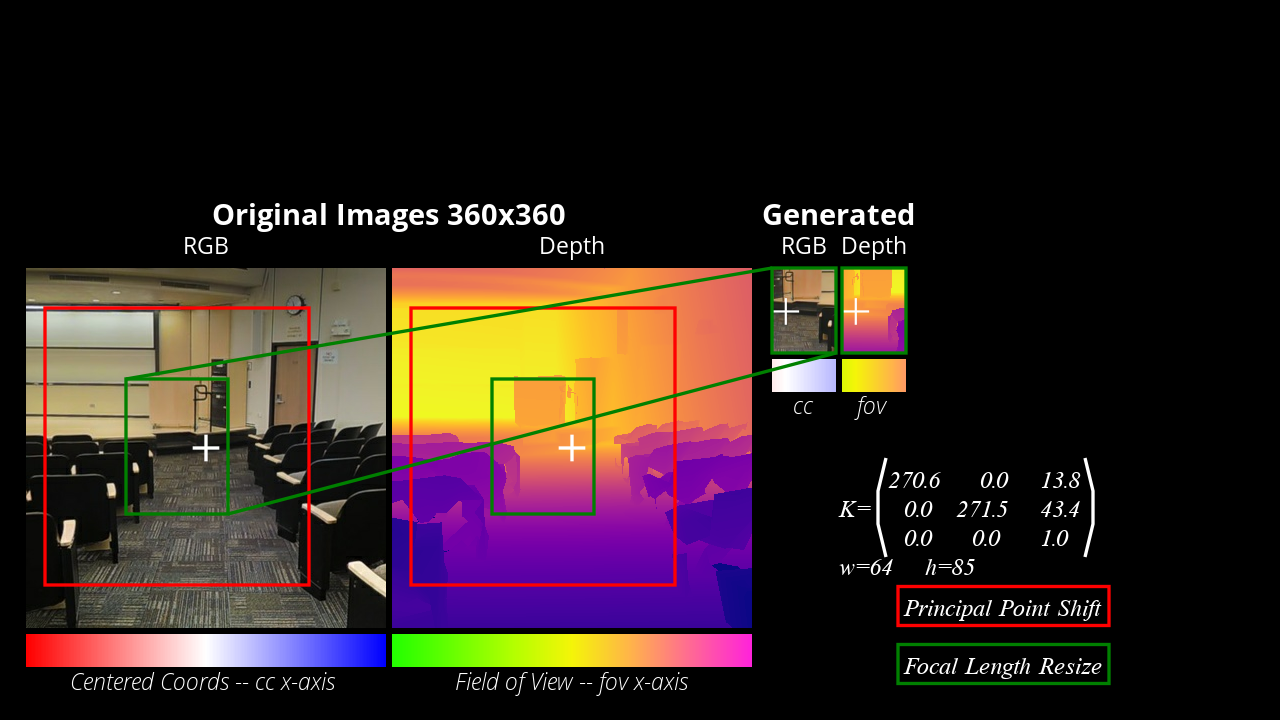

In [10]:
frame,_,_ = get_frame(sess,it)
frame

<h2>Create Sample Video</h2>

In [9]:
video = False
if video:
    import cv2
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
    fr = 25.0 # frame rate
    out = cv2.VideoWriter('demo/video_example.mp4', fourcc, fr, (video_frame_w, video_frame_h))


    target_w = [320//scale,240//scale,400//scale,320//scale,200//scale,320//scale] 
    target_h=  [240//scale,320//scale,240//scale,480//scale,256//scale,320//scale]
    ml=[(item,item,item,item,item,item) for sublist in tfrecords_fn for item in sublist]
    list_of_files =[item for sublist in ml for item in sublist]
    sess = tf.InteractiveSession()
    fixed_frame = None
    percent = 0
    _output=None
    last_x=0


    for index in range(6*6):
        it = get_datareader(list_of_files[index:index+1],
                            target_w=target_w[index%len(target_w)],target_h=target_h[index%len(target_w)])
        it = add_camconvs_channels(it)
        new_area = False
        frames_paused = 9
        for _ in range(frames_paused):
            percent = 0
            _output=None
            frame,output,last_x = get_frame(sess,it,last_frame = fixed_frame,area_n = index+1, 
                                    frame_n=1,percent=percent,output=_output,last_x = last_x)
            for _ in range(5):
                out.write(np.array(frame.convert('RGB'))[..., ::-1])
        _output=output
        for _p in range(15):
            percent=min(1,(_p+1)/15)
            frame,output,last_x = get_frame(sess,it,last_frame = fixed_frame,area_n = index+1, 
                                    frame_n=1,percent=percent,output=_output,last_x = last_x)
            for _ in range(1):
                out.write(np.array(frame.convert('RGB'))[..., ::-1])
        if index%6==5:
            last_x = 0
        fixed_frame=frame
    cv2.destroyAllWindows()
    out.release()    